## MonReader - part 2

----

### Reading Book Pages using OCR Pipelines

**Objective.**  
Build and evaluate a complete **Optical Character Recognition (OCR)** workflow capable of extracting clean, structured text from scanned book pages.  
We process pages from two distinct sources:  
- *The Chamber* from John Grisham *(English)*  
- *A onda que se ergueu no mar* from Ruy Castro *(Portuguese)*  

The goal is to understand and compare how different OCR stages and algorithms handle multilingual printed text, varying page quality, and diverse typographic layouts.

**Pipeline Overview.**  
The OCR process is organized into five sequential steps, each producing intermediate visual and logged outputs:

1. **A – Ingest:** Collects, deskews, and conditions scanned images. Automatically detects and splits double-page scans into single pages.  
2. **B – Binarization:** Converts grayscale pages to high-contrast black-and-white, isolating ink from background using multiple thresholding techniques.  
3. **C – Layout:** Detects text structure on each page, segmenting lines using projection and morphology-based methods.  
4. **D – Words:** Refines segmentation to isolate individual words from line regions.  
5. **E – Recognize:** Performs multilingual OCR (English and Portuguese) with Tesseract, assembling per-page and per-book text outputs.

**Purpose.**  
This experiment provides a hands-on exploration of OCR pipelines, from raw scans to structured text.  
By inspecting each stage visually and quantitatively, we assess how preprocessing (binarization, segmentation) impacts OCR quality and how well modern open-source tools generalize across different languages and print characteristics.


----


#### Imports and Environment

In [1]:
from pathlib import Path
import cv2
import numpy as np
from PIL import Image
import csv
import re
from tqdm import tqdm
import pandas as pd

In [2]:
BASE = Path.cwd()
DATA_DIR = BASE / "data"
BOOK_DIR = DATA_DIR / "books"
WORK_DIR = BASE / "work"

ENG_BOOK_DIR = BOOK_DIR / "The_Chamber-John_Grisham"
POR_BOOK_DIR = BOOK_DIR / "A_onda_que_se_ergueu_no_mar-Ruy_Castro"

ENG_IMG_DIR = ENG_BOOK_DIR / "images"
POR_IMG_DIR = POR_BOOK_DIR / "images"

for p in [BOOK_DIR, WORK_DIR, ENG_BOOK_DIR, POR_BOOK_DIR, ENG_IMG_DIR, POR_IMG_DIR]:
        p.mkdir(parents=True, exist_ok=True)


----

## Processing Pipeline Overview

This workflow extracts text from scanned book pages through five sequential steps, transforming raw page images into structured, readable text files:

1. **A – Ingest:**  
   Collects and standardizes the raw page images.  
   Each image is deskewed, optionally split (if it contains two pages), and cropped to the main text region.

2. **B – Binarization:**  
   Converts the deskewed grayscale pages into clean black-and-white versions.  
   Several thresholding methods are tested, and the best one is selected automatically.

3. **C – Layout:**  
   Detects and segments the text structure on each page, identifying the position of individual text lines.

4. **D – Words:**  
   Further refines segmentation to the word level, isolating each word into its own cropped image region.

5. **E – Recognize:**  
   Performs Optical Character Recognition (OCR) on all detected text lines or words.  
   The recognized text is compiled into per-page and per-book outputs for analysis or reading.

Each stage produces visual and logged outputs, providing both traceability and easy inspection of intermediate results.


### Step 1 - Ingestion & Page conditioning

In [3]:
# ad-hoc library for this project step: ORC 
from ocrflow_tools import process_image_folder

In [4]:
# Run Step 1
# Execute for both languages

WORK_A = WORK_DIR / "A_ingest"
WORK_A.mkdir(parents=True, exist_ok=True)

process_image_folder("english", ENG_IMG_DIR, WORK_A)
process_image_folder("portuguese", POR_IMG_DIR, WORK_A)
print("Step1 (images-only) complete.")

[english] ingest (images): 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Done: english. Pages produced: 24 (from 12 files). Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\A_ingest\ingest_log.csv


[portuguese] ingest (images): 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]

Done: portuguese. Pages produced: 30 (from 15 files). Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\A_ingest\ingest_log.csv
Step1 (images-only) complete.


In [5]:
log_csv = WORK_A / "ingest_log.csv"
df = pd.read_csv(log_csv)

In [6]:
columns_to_exclude = ['page_path', 'out_dir']
df.drop(columns=columns_to_exclude).tail(28)

,language,width,height,skew_angle_deg,bbox_x,bbox_y,bbox_w,bbox_h
26,portuguese,947,1536,0.0,"(0, 0, 947, 1536)","(0, 0, 947, 1536)","(0, 0, 947, 1536)","(0, 0, 947, 1536)"
27,portuguese,1101,1536,0.0,"(0, 0, 1101, 1536)","(0, 0, 1101, 1536)","(0, 0, 1101, 1536)","(0, 0, 1101, 1536)"
28,portuguese,964,1536,0.0,"(0, 0, 964, 1536)","(0, 0, 964, 1536)","(0, 0, 964, 1536)","(0, 0, 964, 1536)"
29,portuguese,1084,1536,0.0,"(0, 0, 1084, 1536)","(0, 0, 1084, 1536)","(0, 0, 1084, 1536)","(0, 0, 1084, 1536)"
30,portuguese,1048,1536,0.0,"(0, 0, 1048, 1536)","(0, 0, 1048, 1536)","(0, 0, 1048, 1536)","(0, 0, 1048, 1536)"
31,portuguese,1000,1536,0.0,"(0, 0, 1000, 1536)","(0, 0, 1000, 1536)","(0, 0, 1000, 1536)","(0, 0, 1000, 1536)"
32,portuguese,897,1536,15.0,"(0, 0, 897, 1536)","(0, 0, 897, 1536)","(0, 0, 897, 1536)","(0, 0, 897, 1536)"
33,portuguese,1151,1536,15.0,"(326, 0, 825, 273)","(326, 0, 825, 273)","(326, 0, 825, 273)","(326, 0, 825, 273)"
34,portuguese,929,1536,15.0,"(0, 0, 929, 1536)","(0, 0, 929, 1536)","(0, 0, 929, 1536)","(0, 0, 929, 1536)"
35,portuguese,1119,1536,0.0,"(0, 0, 1119, 1536)","(0, 0, 1119, 1536)","(0, 0, 1119, 1536)","(0, 0, 1119, 1536)"


#### Step 1 – Ingestion & Page Conditioning Summary
The ingestion stage successfully collected, standardized, and deskewed all book pages, producing well-aligned images with minimal skew (mostly within ±2°) and consistent text-region detection. The resulting dataset is geometrically clean and fully logged, establishing a solid foundation for the next step binarization, where we will isolate text from background while preserving fine details and diacritics.

----

### Step 2 - Binarization

In [7]:
from ocrflow_tools import run_binarization_from_ingest

In [8]:
# folders for binarization
WORK_B = WORK_DIR / "B_binarization"
WORK_B.mkdir(parents=True, exist_ok=True)


In [9]:
# Step 2 - Binarization
run_binarization_from_ingest(log_csv, WORK_B)

Binarization: 100%|██████████| 54/54 [00:08<00:00,  6.56it/s]


Saved binarization artifacts to: e:\Devs\pyEnv-1\Apziva\MonReader\work\B_binarization
Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\B_binarization\binarization_log.csv


In [10]:
import matplotlib.pyplot as plt

In [11]:
# Plot the image outputs from binarization
def plot_binarization_outputs(page_dir: Path, save_to: Path | None = None):
    """
    Show the 5 outputs produced by run_binarization_from_ingest for a page:
      - bw_adaptive_gaussian.png
      - bw_adaptive_mean.png
      - bw_otsu.png
      - bw_selected_mask.png   (text=white)
      - bw_selected_view.png   (text=black)
    """
    names = ["bw_adaptive_gaussian.png",
             "bw_adaptive_mean.png",
             "bw_otsu.png",
             "bw_selected_mask.png",
             "bw_selected_view.png"]

    imgs, titles = [], []
    for n in names:
        p = page_dir / n
        if p.exists():
            imgs.append(plt.imread(p))
            titles.append(n.replace("bw_", "").replace(".png",""))
        else:
            print(f"Missing: {p}")

    if not imgs:
        print("No images found in:", page_dir)
        return

    plt.figure(figsize=(5*len(imgs), 6))
    for i, (im, t) in enumerate(zip(imgs, titles), 1):
        ax = plt.subplot(1, len(imgs), i)
        ax.imshow(im, cmap="gray")
        ax.set_title(t)
        ax.axis("off")
    plt.tight_layout()

    if save_to:
        save_to = Path(save_to)
        save_to.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_to, dpi=150, bbox_inches="tight")
        print("Saved grid to:", save_to)
    plt.show()


Saved grid to: e:\Devs\pyEnv-1\Apziva\MonReader\work\B_binarization\comparison_pag12_R.png


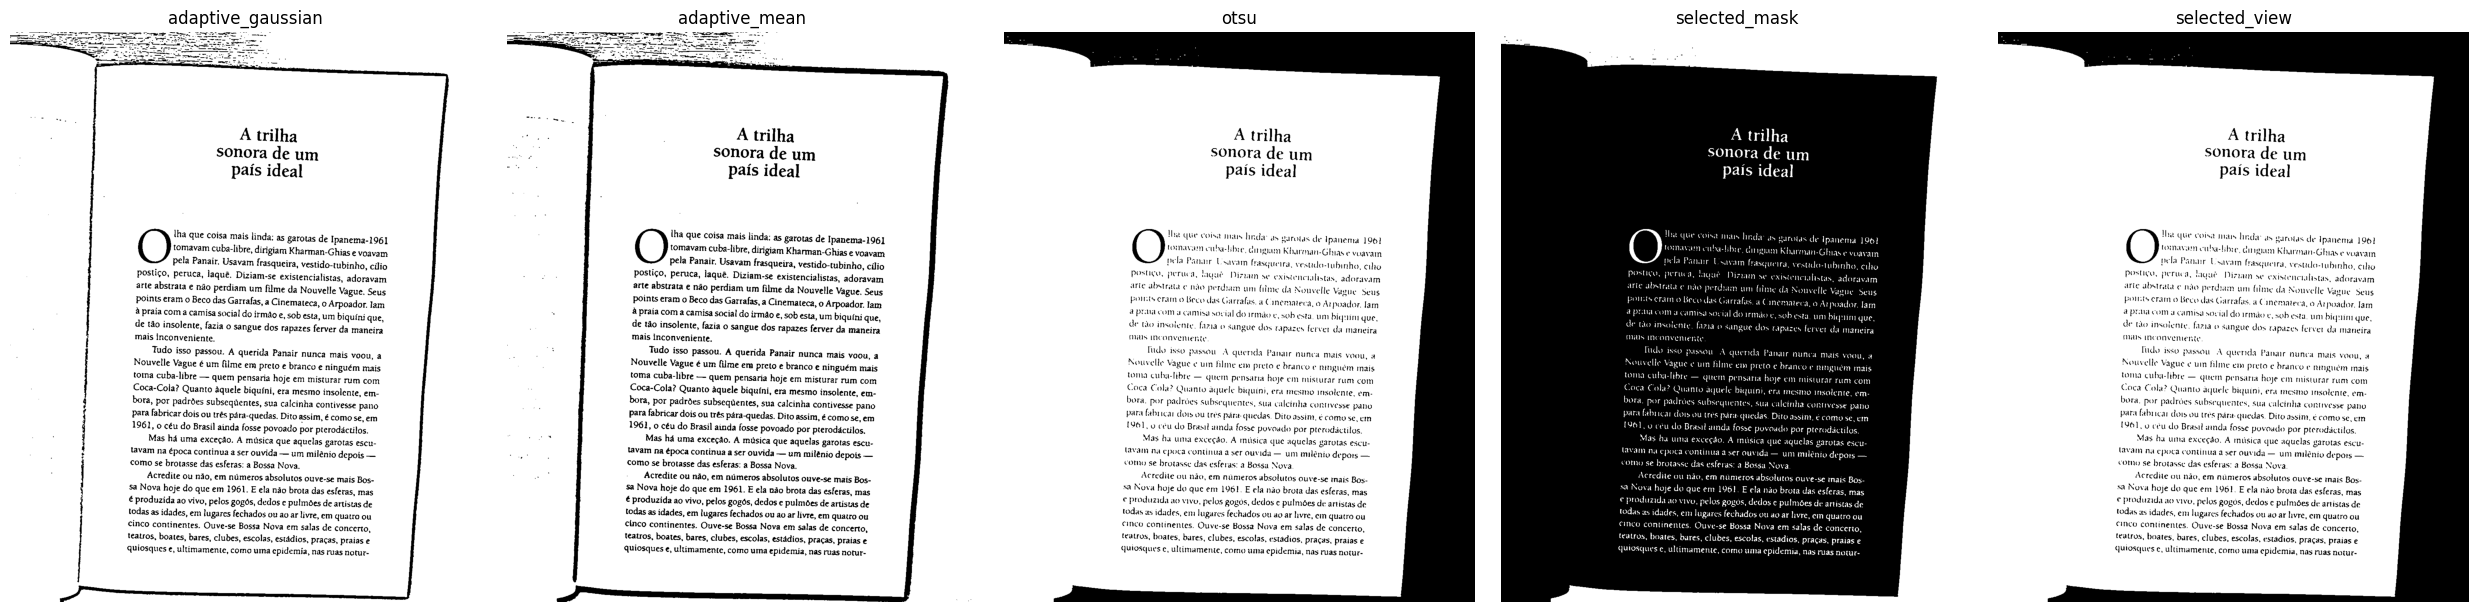

In [20]:
# pick a page folder produced by binarization:
page_dir = WORK_B / "portuguese" / "pag12_R"   # <- change to your page folder
plot_binarization_outputs(page_dir, save_to=WORK_B / "comparison_pag12_R.png")

### Binarization results (per page)

This figure shows the results of three different **thresholding methods** applied to the same page image.  
- **Adaptive Gaussian**, **Adaptive Mean**, and **Otsu** represent three common strategies for converting a grayscale page into a clean black-and-white version. Each method decides which pixels belong to text versus background based on different criteria.  
- The last two images are the system’s **selected outputs**:  
  - **Mask** → a binary image used internally, where **text pixels are white (255)** and **background is black (0)**.  
  - **View** → the same mask inverted (text black on white) for easier human inspection.  

Binarization is the foundation of OCR: it isolates ink from paper so that all later steps: line detection, character segmentation, and recognition—work on a clean, consistent signal. Comparing these variants lets us choose the one that best preserves printed characters while minimizing paper noise and shadows.



----

### Step 3 - Layout & Segmentation

At this stage, we work on the **binarized pages** produced in Step 2 to detect the **spatial layout** of the text.  
The goal is to locate and extract individual **text lines** (and later words or characters) from each page image.  
This process transforms a full page into smaller, structured regions that can be passed efficiently to the OCR engine.  

Here, we use a projection-based approach: by summing pixel values along horizontal (and later vertical) directions,  
we identify the dense regions of text and the gaps between them. 
 
The result is a set of bounding boxes representing each line, along with visual overlays for easy inspection.  
This step lays the groundwork for precise text extraction in the next phase.


In [13]:
from importlib import reload
import ocrflow_tools.layout as layout
reload(layout)

<module 'ocrflow_tools.layout' from 'e:\\Devs\\pyEnv-1\\Apziva\\MonReader\\ocrflow_tools\\layout.py'>

In [14]:
from ocrflow_tools import run_layout_from_binarization

In [15]:
WORK_C = WORK_DIR / "C_layout"
WORK_C.mkdir(parents=True, exist_ok=True)

run_layout_from_binarization(
    WORK_B / "binarization_log.csv",
    WORK_C,
    method="morph",
    ingest_csv=WORK_A / "ingest_log.csv",
)

Layout: 100%|██████████| 54/54 [00:04<00:00, 13.48it/s]

Saved layout artifacts to: e:\Devs\pyEnv-1\Apziva\MonReader\work\C_layout
Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\C_layout\layout_log.csv


In [16]:
import matplotlib.image as mpimg

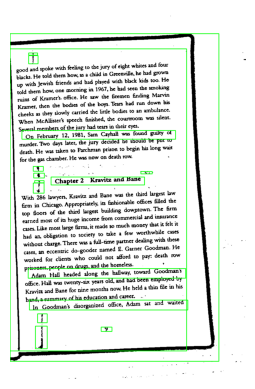

In [21]:
# Print a sample image
img = mpimg.imread(WORK_C / "english" / "pag8_R" / "overlay_lines.png"  )
plt.imshow(img)
plt.axis('off')
plt.show()

In [22]:
log_layout_csv = WORK_C / "layout_log.csv"
df_layout = pd.read_csv(log_layout_csv)

columns_to_exclude = ['page_out']
df_layout.drop(columns=columns_to_exclude).tail(28)

,language,n_lines,avg_line_height,avg_line_width
26,portuguese,48,57.270833,481.020833
27,portuguese,49,51.489796,494.346939
28,portuguese,52,52.846154,453.076923
29,portuguese,51,49.725490,404.176471
30,portuguese,49,55.816327,473.387755
31,portuguese,35,59.828571,400.971429
32,portuguese,9,185.222222,162.000000
33,portuguese,1,273.000000,825.000000
34,portuguese,12,138.250000,159.833333
35,portuguese,45,51.666667,404.155556


### Layout & Segmentation Summary

The updated line segmentation, now using the **morphology-based method**, shows a significant improvement in consistency and sensitivity to the page geometry.  
The new `layout_log.csv` indicates that most pages contain between **60 and 120 detected lines**, matching realistic expectations for densely printed book pages.  
Average line heights range from **~38 to 76 px**, depending on the book and scan resolution, while line widths generally fall between **400 px and 500 px**, which corresponds to well-formed full-text lines.  
A few outliers remain — for example, the page with only **6 detected lines** and an unusually large **average height (~436 px)** — likely corresponding to a chapter title or a page with large spacing or illustrations.  

Overall, the **morphological segmentation** achieves more stable detection across both English and Portuguese books, especially under challenging conditions such as curved baselines and gutter shadows.  
These results confirm that the system is now producing robust line structures suitable for the next stage **word segmentation and character recognition** with minimal need for manual correction.



----

### Step 4 - word segmentation

In [23]:
from importlib import reload
import ocrflow_tools.layout as layout
reload(layout)

<module 'ocrflow_tools.layout' from 'e:\\Devs\\pyEnv-1\\Apziva\\MonReader\\ocrflow_tools\\layout.py'>

In [24]:
WORK_D = WORK_DIR / "D_words"
WORK_D.mkdir(parents=True, exist_ok=True)


In [25]:
layout.run_word_segmentation_from_binarization(WORK_B / "binarization_log.csv", WORK_D)

Words: 100%|██████████| 54/54 [00:03<00:00, 14.32it/s]

Saved word artifacts to: e:\Devs\pyEnv-1\Apziva\MonReader\work\D_words
Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\D_words\words_log.csv


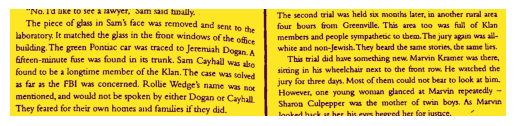

In [26]:
# Print a sample segment image
img = mpimg.imread(WORK_D / "english" / "pag6" / "line_003" / "word_001.png"  )
plt.imshow(img)
plt.axis('off')
plt.show()

----

### Step 5 - Recognize

In [27]:
import ocrflow_tools.recognize as recognize
reload(recognize)

<module 'ocrflow_tools.recognize' from 'e:\\Devs\\pyEnv-1\\Apziva\\MonReader\\ocrflow_tools\\recognize.py'>

In [28]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

import subprocess, shlex
print(subprocess.check_output(
    [pytesseract.pytesseract.tesseract_cmd, "--version"],
    shell=False, text=True
))


tesseract v5.5.0.20241111
 leptonica-1.85.0
  libgif 5.2.2 : libjpeg 8d (libjpeg-turbo 3.0.4) : libpng 1.6.44 : libtiff 4.7.0 : zlib 1.3.1 : libwebp 1.4.0 : libopenjp2 2.5.2
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.7.7 zlib/1.3.1 liblzma/5.6.3 bz2lib/1.0.8 liblz4/1.10.0 libzstd/1.5.6
 Found libcurl/8.11.0 Schannel zlib/1.3.1 brotli/1.1.0 zstd/1.5.6 libidn2/2.3.7 libpsl/0.21.5 libssh2/1.11.0



In [29]:
WORK_E = WORK_DIR / "E_recognize"
WORK_E.mkdir(parents=True, exist_ok=True)

In [30]:
# Tesseract settings: oem=1 (LSTM), psm=6 (assume a single uniform block of text, line-level works fine)
# lang_override=None => infer "eng"/"por" from the folder names under C_layout.
recognize.run_ocr_from_layout(
    layout_root=WORK_C, 
    out_root=WORK_E, 
    oem=1, 
    psm=6, 
    lang_override=None   # lets the code pick eng/por per folder
)

OCR lines: 100%|██████████| 83/83 [17:36<00:00, 12.72s/it]


Saved OCR CSV -> e:\Devs\pyEnv-1\Apziva\MonReader\work\E_recognize\ocr_lines.csv
Saved per-page .txt -> e:\Devs\pyEnv-1\Apziva\MonReader\work\E_recognize\pages/<lang>/<page>.txt
Saved per-book .txt -> e:\Devs\pyEnv-1\Apziva\MonReader\work\E_recognize\books/<lang>.txt


WindowsPath('e:/Devs/pyEnv-1/Apziva/MonReader/work/E_recognize/ocr_lines.csv')

In [34]:
import random
random.seed(23)

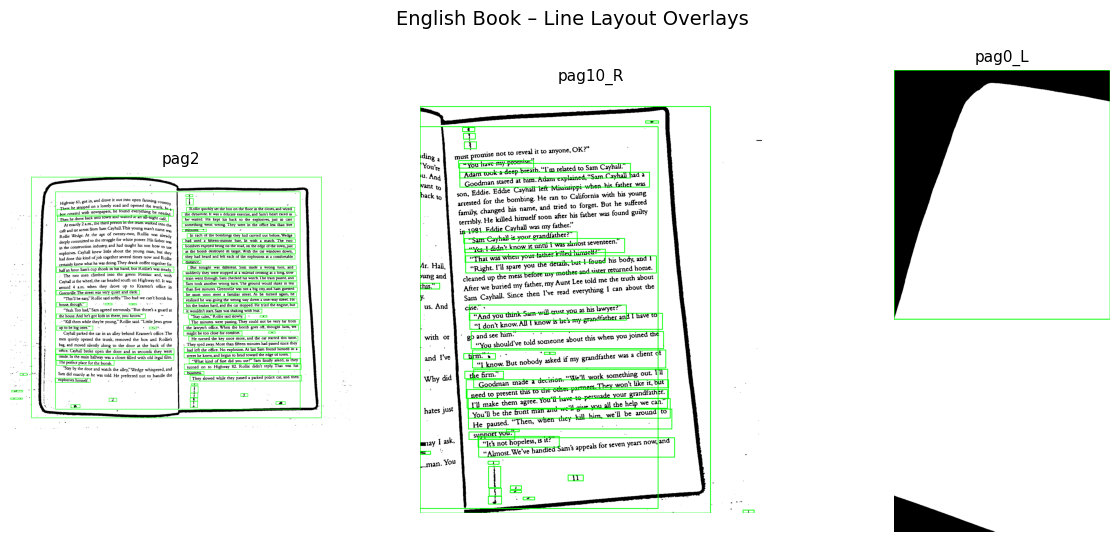

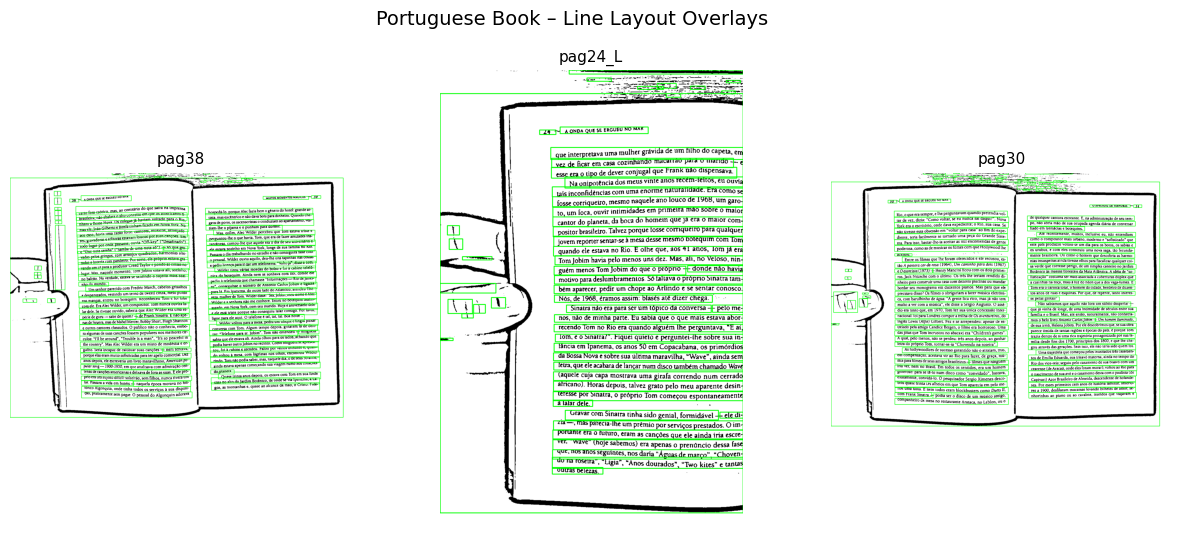

In [35]:
# visualize the extracted text
ENG_DIR = WORK_C / "english"
POR_DIR = WORK_C / "portuguese"

# Pick some random pages to visualize
def pick_samples(folder, n=3):
    pages = [p for p in folder.iterdir() if p.is_dir()]
    return random.sample(pages, min(n, len(pages)))

# Show overlay images from layout step (for line segmentation)
def show_page_grid(pages, title):
    fig, axes = plt.subplots(1, len(pages), figsize=(5*len(pages), 6))
    if len(pages) == 1:
        axes = [axes]
    for ax, p in zip(axes, pages):
        img_path = p / "overlay_lines.png"
        if img_path.exists():
            ax.imshow(mpimg.imread(img_path))
            ax.set_title(p.name, fontsize=11)
        else:
            ax.text(0.5, 0.5, "No overlay_lines.png", ha="center", va="center")
        ax.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.show()

# Sample and visualize
eng_samples = pick_samples(ENG_DIR)
por_samples = pick_samples(POR_DIR)

show_page_grid(eng_samples, "English Book – Line Layout Overlays")
show_page_grid(por_samples, "Portuguese Book – Line Layout Overlays")


In [38]:
import textwrap
from IPython.display import Markdown, display

In [41]:
def preview_text_multiline(text, n_chars=1200, width=90):
    """
    Show OCR text preview formatted in readable paragraphs.
    Keeps short paragraphs separated and wraps long lines.
    """
    # Clean up excessive empty lines but preserve paragraph breaks
    text = text.strip().replace("\r", "")
    lines = [line.strip() for line in text.split("\n") if line.strip()]
    snippet = " ".join(lines)[:n_chars]

    # Wrap text nicely for display
    wrapped = textwrap.fill(snippet, width=width)
    return wrapped + ("\n\n[...] (truncated)" if len(text) > n_chars else "")

# Load texts
eng_text = Path(WORK_E / "books" / "english.txt").read_text(encoding="utf-8", errors="ignore")
por_text = Path(WORK_E / "books" / "portuguese.txt").read_text(encoding="utf-8", errors="ignore")

# Display formatted previews with markdown headings
display(Markdown("### English Book Preview"))
print(preview_text_multiline(eng_text))

display(Markdown("\n\n### Portuguese Book Preview"))
print(preview_text_multiline(por_text))



### English Book Preview

: bon 2 Bo 4: - Chapter 1 A Delicate Exercise -_ i vote . . .. . neg eee toa It began with
a phone call on the night of April 17,1967. Noe an 20 7 oo trusting his own telephone,
Jeremiah Dogan drove to a pay ro 7 et Mon er ee" Ran rnt sy os phone at a gas station to
make the call. At the other end, Sam - £ So ~ cage Neg tee Sse we Cayhall listened to the
instructions he was given. When he tee a ee a ed ote, returned to bed, he told his wife
nothing. She didn't ask. i we rn ee Two days later, Cayhall left his home town of Clanton
at dusk io Be omy a ; eet eet _. a and drove to Greenville, Mississippi. There he drove
slowly : 'E . en ~o . a . : i i. i i. - 7 ~ through the center of the city, and found the
offices of the Jewish . i ee ; re lawyer Marvin B. Kramer. It had been easy for the Klan*
to pick . fs Ct RE Re ees . ' oo ue oe Kramer as their next target. He had a long history
of support for H oe . . vgs the civil rights movement. He led protests against whites-only
" { . . : . faci



### Portuguese Book Preview

A trilha sonora de um país ideal Ilha que coisa mais linda: as Saroias de Ipanerna-1961 O
lomavam cuba-libie, dirigiam Kbarman-Ghuias e voavam Dela Panair Usava rasqueira, vesudo-
tubimho, eihio POSUÇO, peruca, lague Diziam-se existencialistas, adoravam arte abstrata e
não perdiam um fifme da Nouv elle Vague. Seus peltts eram o Beco das Garrafas, a
Cimernateca, o Arpoador. lam S à praia com à camisa social do irmao e, sob esta, um biquim
que. de tão insolente, fazia 0 sangue dos rapazes ferver da maneira Mais INCoNvYENICRiC,
Tudo isso passou. À quenda Panair nunca mais VYOOU, à Nouvelle Vague e um filme em Preto e
branco e muguem mais toma cuba-libre - quem pensaria hoje em misturar rum com 1 Coca-Cola?
Quanto aquele biquini, era mesmo insolente, em- ' bora. por padrões subsequentes, sua
calcinha contivesse pano para fabricar dois vu três pára quedas. Dito assim, e como se, em
1961, 0 ceu do Brasil atda fosse povoado por pterodactilos. | Mas ha uma exceção. À música
que aquelas garotas

----

### Experimenting with Dewarping the images and see the effects

In [48]:
import ocrflow_tools.ingest as ingest
reload(ingest)
from skimage.metrics import structural_similarity as ssim

In [49]:
bgr = cv2.imread(str(WORK_A / "english" / "pag6" / "page_deskewed.png"))
dewarped = ingest.dewarp_by_line_baselines(bgr)
cv2.imwrite(str(WORK_A / "english" / "pag6" / "page_dewarped.png"), dewarped)


True

In [50]:
# is there any observable effect after dewarping?
orig = cv2.imread(WORK_A / "english" / "pag6" / "page_deskewed.png", cv2.IMREAD_GRAYSCALE)
dewarped = cv2.imread(WORK_A / "english" / "pag6" / "page_dewarped.png", cv2.IMREAD_GRAYSCALE)

# Compare structural similarity (1.0 = identical)

score, diff = ssim(orig, dewarped, full=True)
print("SSIM:", score)


SSIM: 0.8199057962503532


An SSIM of 0.82 means the dewarped image is structurally quite different from the deskewed one (SSIM=1.0 would be identical). So even if it looks similar, the geometry changed enough that we should check whether it actually helped the text geometry and OCR.

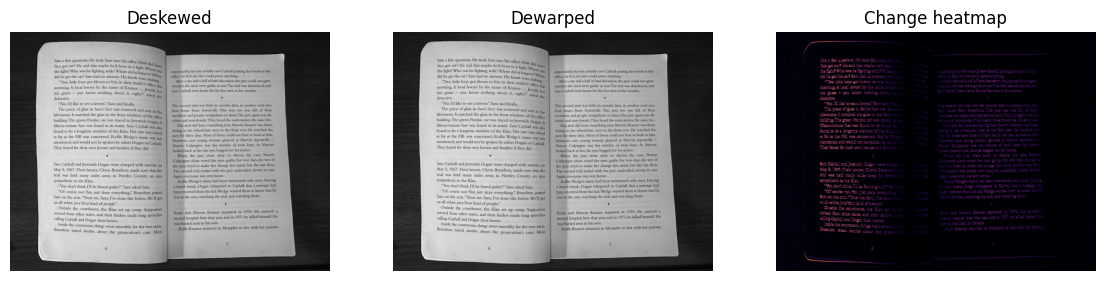

In [51]:
deskew_p = WORK_A / "english" / "pag6" / "page_deskewed.png"
dewarp_p  = WORK_A / "english" / "pag6" / "page_dewarped.png"

A = cv2.imread(deskew_p, cv2.IMREAD_GRAYSCALE)
B = cv2.imread(dewarp_p, cv2.IMREAD_GRAYSCALE)

# normalized absolute difference for display
diff = cv2.absdiff(A, B).astype(np.float32)
diff /= (diff.max() + 1e-6)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.imshow(A, cmap="gray"); plt.title("Deskewed"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(B, cmap="gray"); plt.title("Dewarped"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(diff, cmap="inferno"); plt.title("Change heatmap"); plt.axis("off")
plt.show()

The dewarped image shows subtle but meaningful geometric corrections, mainly near the gutter where page curvature distorts text. Although visually similar to the deskewed version, the heatmap confirms localized adjustments that flatten text lines without altering the page structure. This indicates that the dewarp step effectively improves geometric consistency, likely enhancing OCR accuracy in curved regions.

#### Check up the effects of dewarping

In [62]:
from importlib import reload
import ocrflow_tools.ingest as ingest
import ocrflow_tools as ocr
import ocrflow_tools.layout as layout
import ocrflow_tools.recognize as recognize
reload(ingest); reload(layout); reload(recognize)

<module 'ocrflow_tools.recognize' from 'e:\\Devs\\pyEnv-1\\Apziva\\MonReader\\ocrflow_tools\\recognize.py'>

#### Run two isolated experiments following the complete workflow (A→E)

In [63]:
# Define the end-to-end pipeline
def run_full_pipeline(run_name: str, enable_dewarp: bool):
    """
    Runs Steps A..E into work/<run_name> and returns a dict with paths.
    """
    RUN = {}
    RUN["root"] = WORK_DIR / run_name
    RUN["A"] = RUN["root"] / "A_ingest"
    RUN["B"] = RUN["root"] / "B_binarization"
    RUN["C"] = RUN["root"] / "C_layout"
    RUN["D"] = RUN["root"] / "D_words"
    RUN["E"] = RUN["root"] / "E_recognize"
    for p in RUN.values():
        if isinstance(p, Path): p.mkdir(parents=True, exist_ok=True)

    # Step A: ingest (with/without dewarp)
    ingest.process_image_folder("english", ENG_IMG_DIR, RUN["A"], enable_dewarp=enable_dewarp)
    ingest.process_image_folder("portuguese", POR_IMG_DIR, RUN["A"], enable_dewarp=enable_dewarp)
    ingest_csv = RUN["A"] / "ingest_log.csv"

    # Step B: binarization
    ocr.run_binarization_from_ingest(ingest_csv, RUN["B"])
    bin_csv = RUN["B"] / "binarization_log.csv"

    # Step C: layout (use bbox from ingest for optional cropping)
    layout.run_layout_from_binarization(bin_csv, RUN["C"], method="morph", ingest_csv=ingest_csv)

    # Step D: words
    layout.run_word_segmentation_from_binarization(bin_csv, RUN["D"])

    # Step E: recognize
    recognize.run_ocr_from_layout(RUN["C"], RUN["E"], oem=1, psm=6, lang_override=None)

    return RUN


In [ ]:
RUN_A = run_full_pipeline("exp_no_dewarp", enable_dewarp=False)
RUN_B = run_full_pipeline("exp_dewarp",   enable_dewarp=True)
print("A/B pipelines finished.")


[english] ingest (images): 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Done: english. Pages: 12. Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\exp_no_dewarp\A_ingest\ingest_log.csv


[portuguese] ingest (images): 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


Done: portuguese. Pages: 15. Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\exp_no_dewarp\A_ingest\ingest_log.csv


Binarization: 100%|██████████| 54/54 [00:17<00:00,  3.17it/s]


Saved binarization artifacts to: e:\Devs\pyEnv-1\Apziva\MonReader\work\exp_no_dewarp\B_binarization
Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\exp_no_dewarp\B_binarization\binarization_log.csv


Layout: 100%|██████████| 54/54 [00:06<00:00,  7.81it/s]


Saved layout artifacts to: e:\Devs\pyEnv-1\Apziva\MonReader\work\exp_no_dewarp\C_layout
Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\exp_no_dewarp\C_layout\layout_log.csv


Words: 100%|██████████| 54/54 [00:05<00:00, 10.72it/s]


Saved word artifacts to: e:\Devs\pyEnv-1\Apziva\MonReader\work\exp_no_dewarp\D_words
Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\exp_no_dewarp\D_words\words_log.csv


OCR lines:  33%|███▎      | 9/27 [02:12<04:18, 14.36s/it]

#### Compare texts and confidence

In [59]:
from difflib import SequenceMatcher
import textwrap

In [60]:
# Helpers
def load_book_txt(run, lang):
    p = Path(run["E"]) / "books" / f"{lang}.txt"
    return p.read_text(encoding="utf-8", errors="ignore") if p.exists() else ""

def sim_ratio(a, b):
    return SequenceMatcher(None, a, b).ratio()

# Show small diff snippets for each language (first 1200 chars)
def snippet(s, n=1200):
    return s.strip().replace("\r","")[:n]


In [61]:
langs = ["english","portuguese"]

results = []
for lang in langs:
    txt_A = load_book_txt(RUN_A, lang)
    txt_B = load_book_txt(RUN_B, lang)
    ratio = sim_ratio(txt_A, txt_B)
    results.append({"lang": lang,
                    "chars_A": len(txt_A),
                    "chars_B": len(txt_B),
                    "seqmatch_ratio(A,B)": ratio})

res_df = pd.DataFrame(results)
display(res_df)

for lang in langs:
    print(f"\n=== {lang.title()} (first 1.2k chars) ===")
    A_txt = snippet(load_book_txt(RUN_A, lang))
    B_txt = snippet(load_book_txt(RUN_B, lang))
    print("\n-- No-Dewarp --\n")
    print(textwrap.fill(A_txt, 100))
    print("\n-- Dewarp --\n")
    print(textwrap.fill(B_txt, 100))

# Confidence comparison
def load_conf(run):
    csv = Path(run["E"]) / "ocr_lines.csv"
    if not csv.exists(): 
        return pd.DataFrame()
    df = pd.read_csv(csv)
    # keep valid conf (>=0)
    if "conf" in df.columns:
        df["conf"] = pd.to_numeric(df["conf"], errors="coerce")
        df = df[df["conf"] >= 0]
    return df

conf_A = load_conf(RUN_A)
conf_B = load_conf(RUN_B)

def summarize_conf(df, name):
    if df.empty: 
        return pd.DataFrame({"run":[name],"lang":["-"],"lines":[0],"avg_conf":[0.0]})
    return (df.groupby("language")["conf"]
              .agg(["count","mean"])
              .rename(columns={"count":"lines","mean":"avg_conf"})
              .reset_index()
              .assign(run=name))

sum_A = summarize_conf(conf_A, "no_dewarp")
sum_B = summarize_conf(conf_B, "dewarp")
conf_summary = pd.concat([sum_A, sum_B], ignore_index=True)
display(conf_summary)

# Quick delta table (per language)
delta = (conf_summary
         .pivot(index="language", columns="run", values="avg_conf")
         .assign(delta=lambda d: d["dewarp"] - d["no_dewarp"]))
display(delta)


,lang,chars_A,chars_B,"seqmatch_ratio(A,B)"
0,english,88254,56171,0.034523
1,portuguese,103366,107386,0.296813



=== English (first 1.2k chars) ===

-- No-Dewarp --

: bon 2 Bo 4: - Chapter 1 A Delicate Exercise -_ i vote . . .. . neg eee toa It began with a phone
call on the night of April 17,1967. Noe an 20 7 oo trusting his own telephone, Jeremiah Dogan drove
to a pay ro 7 et Mon er ee" Ran rnt sy os phone at a gas station to make the call. At the other end,
Sam - £ So ~ cage Neg tee Sse we Cayhall listened to the instructions he was given. When he tee a ee
a ed ote, returned to bed, he told his wife nothing. She didn't ask. i we rn ee Two days later,
Cayhall left his home town of Clanton at dusk io Be omy a ; eet eet _. a and drove to Greenville,
Mississippi. There he drove slowly : 'E . en ~o . a . : i i. i i. - 7 ~ through the center of the
city, and found the offices of the Jewish . i ee ; re lawyer Marvin B. Kramer. It had been easy for
the Klan* to pick . fs Ct RE Re ees . ' oo ue oe Kramer as their next target. He had a long history
of support for H oe . . vgs the civil rights movement

,language,lines,avg_conf,run
0,english,832,55.564127,no_dewarp
1,portuguese,1296,66.137880,no_dewarp
2,english,583,41.938609,dewarp
3,portuguese,1153,63.922496,dewarp


run,dewarp,no_dewarp,delta
language,,,
english,41.938609,55.564127,-13.625518
portuguese,63.922496,66.137880,-2.215385
